# Zadanie 5

Celem ćwiczenia jest implementacja algorytmu Q-learning.

Następnie należy stworzyć agenta rozwiązującego problem [Taxi](https://gymnasium.farama.org/environments/toy_text/taxi/). Problem dostępny jest w pakiecie **gym**.

Punktacja (max 7 pkt):
- Implementacja algorytmu Q-learning. [3 pkt]
- Eksperymenty dla różnych wartości hiperparametrów [2 pkt]
- Jakość kodu [1 pkt]
- Wnioski [1 pkt]


In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

In [ ]:

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1

!pip install gym[atari] > /dev/null 2>&1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.5/819.5 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
!apt update
!apt install xvfb

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
42 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
T

#Implementacja

In [ ]:
class QLearningSolver:
    """Class containing the Q-learning algorithm that might be used for different discrete environments."""

    def __init__(
        self,
        observation_space: int,
        action_space: int,
        learning_rate: float = 1,
        gamma: float = 0.9,
        epsilon: float = 0.1,
    ):
        self.observation_space = observation_space  # z środowiska
        self.action_space = action_space  # z środowiska
        self.learning_rate = learning_rate
        self.gamma = gamma  # jak bardzo patrzy w przód
        self.epsilon = epsilon  # jak często wybierać losową
        self.q_table: np.ndarray = np.array([])
        self._init_q_table()

    def _init_q_table(self):  # done
        self.q_table = np.zeros((self.observation_space, self.action_space))

    def __call__(self, state: np.ndarray, action: np.ndarray) -> np.ndarray:  # done
        """Return Q-value of given state and action."""
        return np.array(self.q_table[state.item(), action.item()])

    def update(
        self,
        state: np.ndarray,
        action: np.ndarray,
        reward: float,
        future_state: np.ndarray,
    ) -> None:  # tu nie było future state
        # tu trochę jest problem ze zdobićeim stanu następnego
        """Update Q-value of given state and action."""
        self.q_table[state.item(), action.item()] += self.learning_rate * (
            reward
            + self.gamma
            * self.__call__(future_state, self.get_best_action(future_state))
            - self.q_table[state.item(), action.item()]
        )

    def get_best_action(self, state: np.ndarray) -> np.ndarray:
        """Return action that maximizes Q-value for a given state."""
        return np.array(np.argmax(self.q_table[state, :]))

    def __repr__(self):
        """Elegant representation of Q-learning solver."""
        return ""

    def __str__(self):
        return self.__repr__()

In [ ]:
def q_leraning_single_epizode(
    enviornemt: gym.Env, solver: QLearningSolver, t_max: int
):
    t = 0
    state = enviornemt.reset()
    terminated = False
    while t <= t_max and not terminated:
        action = (
            solver.get_best_action(np.array(state))
            if np.random.rand(1) > solver.epsilon
            else np.array(enviornemt.action_space.sample())
        )
        observation, reward, terminated, info = enviornemt.step(action.item())
        solver.update(np.array(state), np.array(action), reward, np.array(observation))
        state = observation
        t += 1


def q_leraning(
    enviornemt: gym.Env,
    solver: QLearningSolver,
    t_max: int,
    epizodes: int,
):
    for _ in range(epizodes):
        q_leraning_single_epizode(enviornemt, solver, t_max)

#Testing Methods

In [ ]:
from IPython import display
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
from matplotlib import animation

def animate_result(env: gym.Env, solver: QLearningSolver):
  img = []
  fig, ax = plt.subplots()
  plt.close()
  ax.set_xlim(( 0, 2))
  ax.set_ylim((-2, 2))
  line, = ax.plot([], [], lw=2)
  rewards = []
  state = env.reset()
  step = 0
  done = False
  for step in range(30):
      action = np.argmax(solver.q_table[state,:])
      new_state, reward, done, info = env.step(action)
      img.append(env.render('rgb_array'))
      rewards.append(reward)
      if done:
          break
          print(step)
      state = new_state
  env.close()
  dpi = 72
  interval = 150
  plt.figure(figsize=(img[0].shape[1]/dpi,img[0].shape[0]/dpi),dpi=dpi)
  patch = plt.imshow(img[0])
  plt.axis=('off')
  animate = lambda i: patch.set_data(img[i])
  ani = animation.FuncAnimation(plt.gcf(),animate,frames=len(img),interval=interval)
  display.display(display.HTML(ani.to_jshtml()))
  return rewards


def test_results(env: gym.Env, solver: QLearningSolver, episodes: int, max_steps_per_episode: int = 30):
  succeses = 0
  total_reward = []
  for i in range(episodes):
    state = env.reset()
    total_reward.append(0)
    for step in range(max_steps_per_episode):
      action = np.argmax(solver.q_table[state,:])
      new_state, reward, done, info = env.step(action)
      total_reward[i] += reward
      if done:
          succeses += 1
          break
      state = new_state
  return succeses, total_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_test_results(reward_results:list, complition_results:list, x_axis_values:list, title:str, xlable:str):
  plt.plot(x_axis_values ,reward_results)
  plt.xlabel(xlable)
  plt.ylabel("Wartość sumaryczna nagrody za próbę")
  plt.title(f"{title}, wartość sumaryczna nagrody za próbę")
  plt.show()
  plt.plot(x_axis_values ,complition_results)
  plt.xlabel(xlable)
  plt.ylabel("Średnia ilośc sukcesów")
  plt.title(f"{title}, średnia ilośc sukcesów")
  plt.show()

# Prezentacja działania


In [ ]:
env = gym.make('Taxi-v3')
solver = QLearningSolver(env.observation_space.n, env.action_space.n, epsilon=0.2, learning_rate=0.7, gamma=0.7)
q_leraning(env, solver, 100, 3000)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
animate_result(env, solver)

Output hidden; open in https://colab.research.google.com to view.

#Uwagi do testów


W testach do badania jakości solvera użyłem metody testującej która pozwalała na wykonanie maksymalnie 20 ruchów na jedną próbę. Taka ilość ruchów odpowiada ruchom potrzebnym do dostarczenia pasarzera w najgorszym przypadku.

#Test ilości epizodów

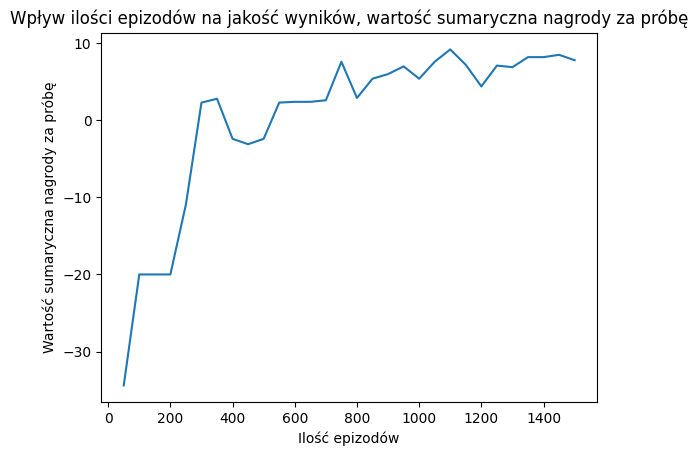

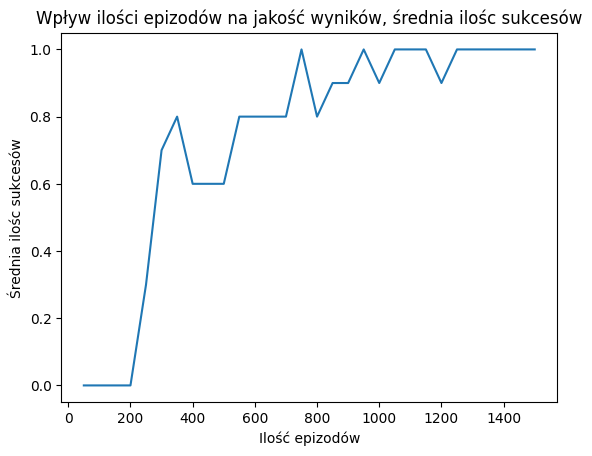

In [ ]:
solver = QLearningSolver(500, 6, epsilon=0.2, learning_rate=0.7, gamma=0.7)

test_runs = 10
epizode_incrementation_per_datapoint = 50
number_of_datapoints = 30

env = gym.make('Taxi-v3')
reward_results = []
complition_results = []
for i in range(number_of_datapoints):
  q_leraning(env, solver, 100, epizode_incrementation_per_datapoint)
  test_result = test_results(env, solver, test_runs, max_steps_per_episode=20)
  reward_results.append(sum(test_result[1])/test_runs)
  complition_results.append(test_result[0]/test_runs)
plot_test_results(reward_results, complition_results, range(epizode_incrementation_per_datapoint, number_of_datapoints*epizode_incrementation_per_datapoint+1, epizode_incrementation_per_datapoint), "Wpływ ilości epizodów na jakość wyników", "Ilość epizodów")

Wraz ze zwiększaniem się ilości epizodów testowych zwiększa się jakość algorytmu. Pierwsze wygrane dostajemy dopiero po użyciu 250 epizodów testowych, potem wzrost ma charakter logarytmiczny. Po około 1000 epizodach wzrost jest już na tyle wolny, że różnica w średniej ilości sukcesów i sumarycznemu błędowi próby jest nieznaczna. Oczywiści dla mniejszej ilości epizodów jest większa szansa, że trafi się przypadek, który nie zostął wzięty pod uwagę podczas trenowania dlatego warto wziąć nieco większą ilość epizodów. W naszym wypadku najlepszym stosunkiem czsu do stabilności rozwiązania jest 1200 epizodów. Oczywiści bezpieczniej byłoby wziąć większą liczbę epizodów (np.: 1400 lub nawet 2000), ale uznałem że 1200 epizodów daje wystarczająco dobre wyniki i nie wymaga za dużego nakładu obliczeń.

#Test ilości mksymalnych kroków przy epizodach

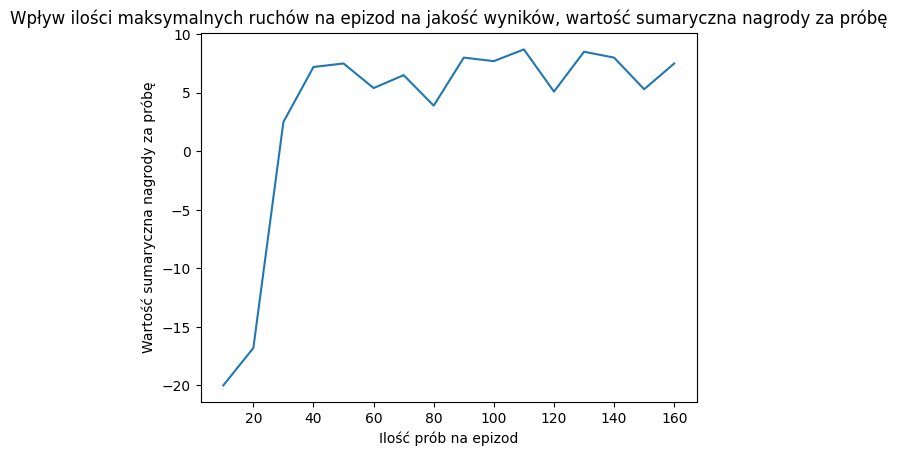

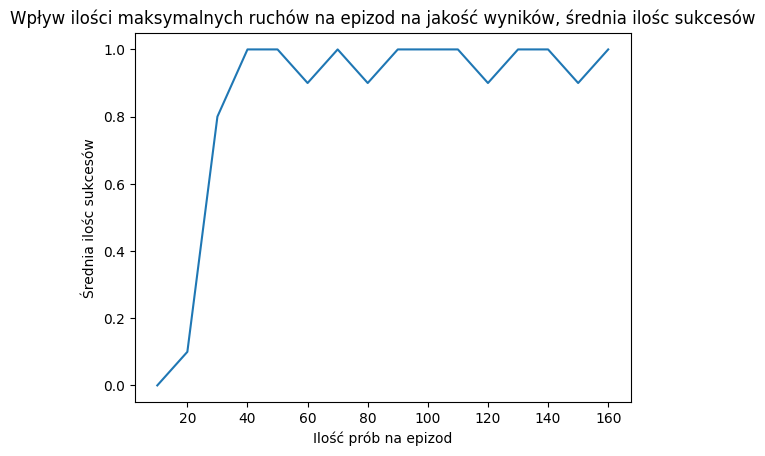

In [ ]:
env = gym.make('Taxi-v3')
results = []

test_runs = 10
max_steps_increment_per_datapoint = 10
biggest_number_of_steps = 160

epizodes = 1200

atempts = 1
for j in range(atempts):
  reward_results = []
  complition_results = []
  for i in range(max_steps_increment_per_datapoint, biggest_number_of_steps+1, max_steps_increment_per_datapoint):
    solver = QLearningSolver(500, 6, epsilon=0.2, learning_rate=0.7, gamma=0.7)
    q_leraning(env, solver, i, epizodes)
    test_result = test_results(env, solver, test_runs, max_steps_per_episode=20)
    reward_results.append(sum(test_result[1])/test_runs)
    complition_results.append(test_result[0]/test_runs)

  plot_test_results(reward_results, complition_results, range(max_steps_increment_per_datapoint, biggest_number_of_steps+1, max_steps_increment_per_datapoint), "Wpływ ilości maksymalnych ruchów na epizod na jakość wyników", "Ilość prób na epizod")

Wraz ze zwiększaniem się ilości maksymalnych epizodów zwiększa się jakość wyników (czyli jest większa szansa na sukces). Dla około 40 kroków suma nagród i średnia ilość wygranych się stabilizują i tylko czasami są nieznaczne odchylenia. Więc wraz ze zwiększająca się ilością powyżej 40 nie zyskujemy dużo większej dokładności, dlatego najlepszą wartością tego parametru jest 60.

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


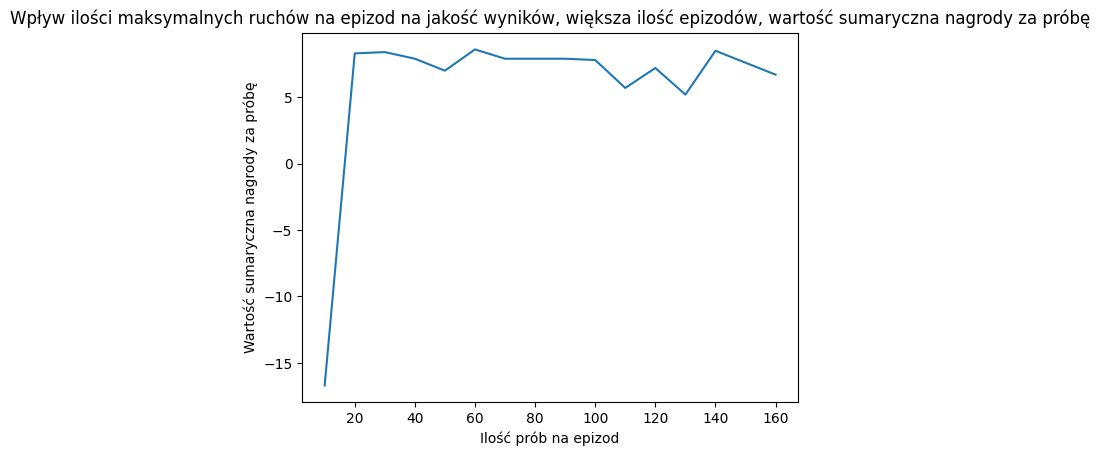

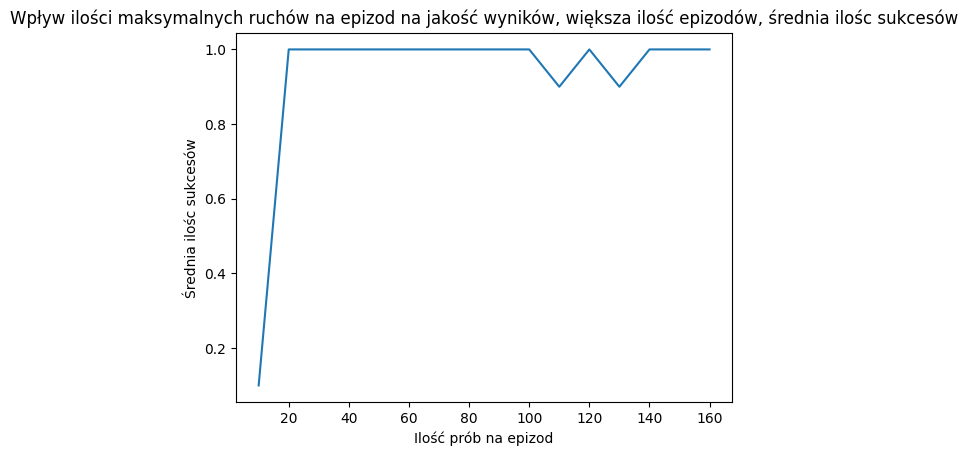

In [ ]:
env = gym.make('Taxi-v3')
results = []

test_runs = 10
max_steps_increment_per_datapoint = 10
biggest_number_of_steps = 160
epizodes = 2000

atempts = 1
for j in range(atempts):
  reward_results = []
  complition_results = []
  for i in range(max_steps_increment_per_datapoint, biggest_number_of_steps+1, max_steps_increment_per_datapoint):
    solver = QLearningSolver(500, 6, epsilon=0.2, learning_rate=0.7, gamma=0.7)
    q_leraning(env, solver, i, epizodes)
    test_result = test_results(env, solver, test_runs, max_steps_per_episode=20)
    reward_results.append(sum(test_result[1])/test_runs)
    complition_results.append(test_result[0]/test_runs)

  plot_test_results(reward_results, complition_results, range(max_steps_increment_per_datapoint, biggest_number_of_steps+1, max_steps_increment_per_datapoint), "Wpływ ilości maksymalnych ruchów na epizod na jakość wyników, większa ilość epizodów", "Ilość prób na epizod")

#Wpływ epsilon na jakość wyników


W tej sekcji w celu lepszej prezentacji liczbę epizodów zmniejszyłem do 700 z 1200

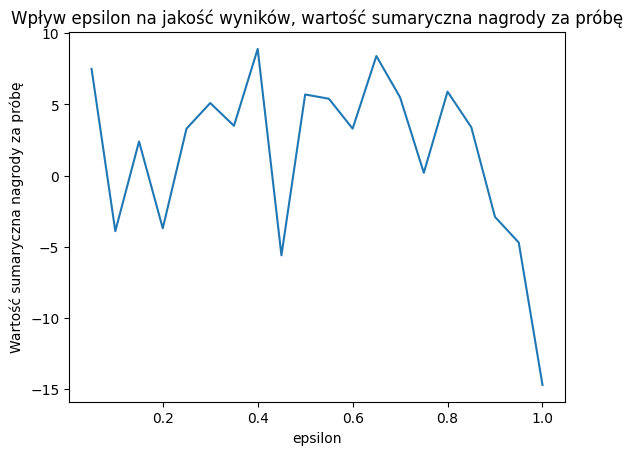

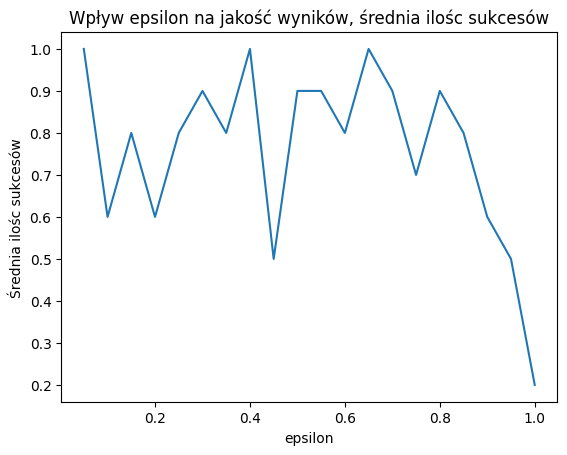

In [ ]:
env = gym.make('Taxi-v3')
results = []

test_runs = 10
epsilon_increment_per_datapoint = 0.05
max_epsilon = 1
liczba_epizodów = 700

reward_results = []
complition_results = []

for i in np.arange(epsilon_increment_per_datapoint, max_epsilon+epsilon_increment_per_datapoint, epsilon_increment_per_datapoint):
  solver = QLearningSolver(500, 6, epsilon=i, learning_rate=0.7, gamma=0.7)
  q_leraning(env, solver, 80, liczba_epizodów)
  test_result = test_results(env, solver, test_runs, max_steps_per_episode=20)
  reward_results.append(sum(test_result[1])/test_runs)
  complition_results.append(test_result[0]/test_runs)

plot_test_results(reward_results, complition_results, np.arange(epsilon_increment_per_datapoint, max_epsilon+epsilon_increment_per_datapoint, epsilon_increment_per_datapoint), "Wpływ epsilon na jakość wyników", "epsilon")

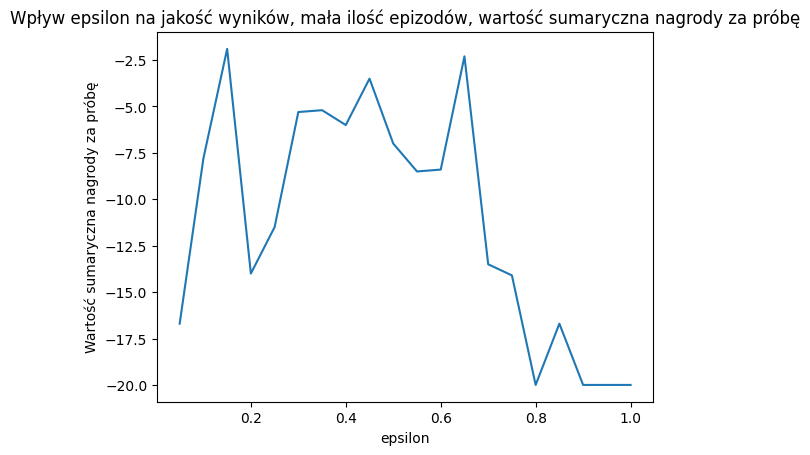

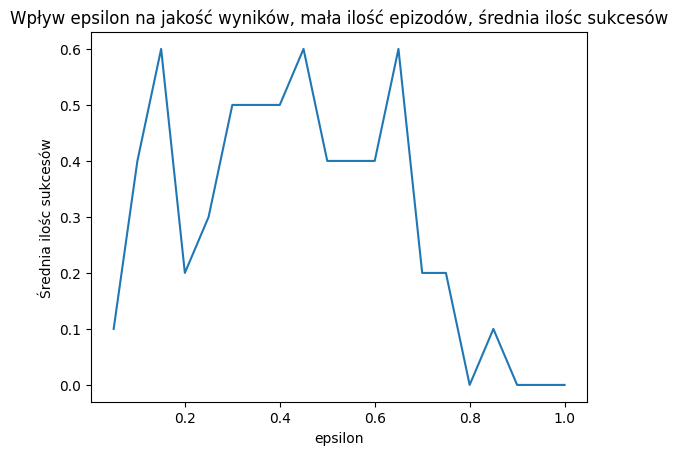

In [ ]:
env = gym.make('Taxi-v3')
results = []

test_runs = 10
epsilon_increment_per_datapoint = 0.05
max_epsilon = 1
liczba_epizodów = 400

reward_results = []
complition_results = []

for i in np.arange(epsilon_increment_per_datapoint, max_epsilon+epsilon_increment_per_datapoint, epsilon_increment_per_datapoint):
  solver = QLearningSolver(500, 6, epsilon=i, learning_rate=0.7, gamma=0.7)
  q_leraning(env, solver, 80, liczba_epizodów)
  test_result = test_results(env, solver, test_runs, max_steps_per_episode=20)
  reward_results.append(sum(test_result[1])/test_runs)
  complition_results.append(test_result[0]/test_runs)

plot_test_results(reward_results, complition_results, np.arange(epsilon_increment_per_datapoint, max_epsilon+epsilon_increment_per_datapoint, epsilon_increment_per_datapoint), "Wpływ epsilon na jakość wyników, mała ilość epizodów", "epsilon")

Dla epsilon powyżej 0.7 jest mała szansa na otrymanie dobrych wyników, może to częściowo wynikać z tego, że dla małej ilości epizodów nie wszystkie wartości w tablicy Q są wypełnione, a przy dużym epsilon jest mała szansa, że ścieżka rozwiązująca przypadek, będzie znajdywać się w tych uzupełnionych. Dla epsilon od 0.3 do 0.7 wyniki raczej są stabilne w każdej próbie. Natomiast dla epsilone 0.3 wyniki bardzo oscylują, może to wynikac z tego, że algorytm bardzo uzależnia się od miejsca startu i nie uaktualnia wartości dla innych punktów startowych i ackji.

Dla większej ilości epizodów przedział w którym wyniki są stabilne poszeża się, dlatego najlepszą wartością epsilon będzie nie za duż wartość, a zarazem nie za mała np.: 0.3

#Wpływ Gamma na jakość wyników

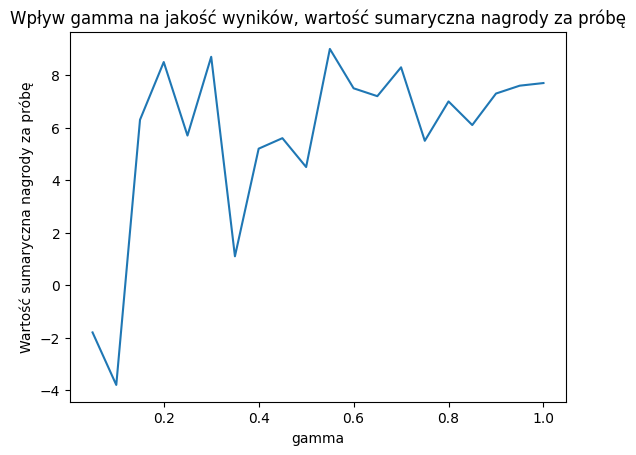

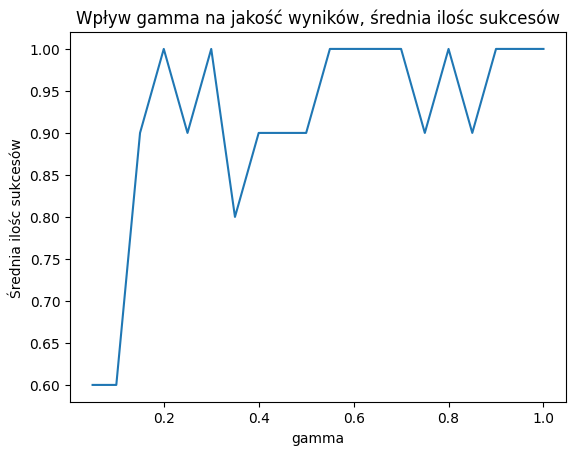

In [ ]:
env = gym.make('Taxi-v3')
results = []

test_runs = 10
gamma_increment_per_datapoint = 0.05
max_gamma = 1
liczba_epizodów = 1200

reward_results = []
complition_results = []

for i in np.arange(gamma_increment_per_datapoint, max_gamma+gamma_increment_per_datapoint, gamma_increment_per_datapoint):
  solver = QLearningSolver(500, 6, epsilon=0.5, learning_rate=0.7, gamma=i)
  q_leraning(env, solver, 80, liczba_epizodów)
  test_result = test_results(env, solver, test_runs, max_steps_per_episode=20)
  reward_results.append(sum(test_result[1])/test_runs)
  complition_results.append(test_result[0]/test_runs)

plot_test_results(reward_results, complition_results, np.arange(gamma_increment_per_datapoint, max_gamma+gamma_increment_per_datapoint, gamma_increment_per_datapoint), "Wpływ gamma na jakość wyników", "gamma")

Wraz ze zwiększającym się gamma algorytm patrzy "bardziej do przodu", a co za tym idzie bardziej bierze pod uwagę ruchy które może wykonać w przyszłości. Dla rosnących wartości gamma, średnia sumaryczna nagroda testu rośnie. To samo dzieje się dla średniej ilości sukcesów. Powyżej gamma 0,6 jakość algorytmu się stabilizuje i nie widać znacznych różnic (ale małe są).

Wartoś wybrać wyskoą wartość gamma, aby algorytm mógł "przewidywać" przyszłe róchy, ale nie można wziąć za dużej, aby za bardzo się nie skupiał na tej przyszłości. Dlatego według mnie dla tego środowiska najlepsze jest gamma 0,85

#Wpływ Learning Rate na jakość wyników

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


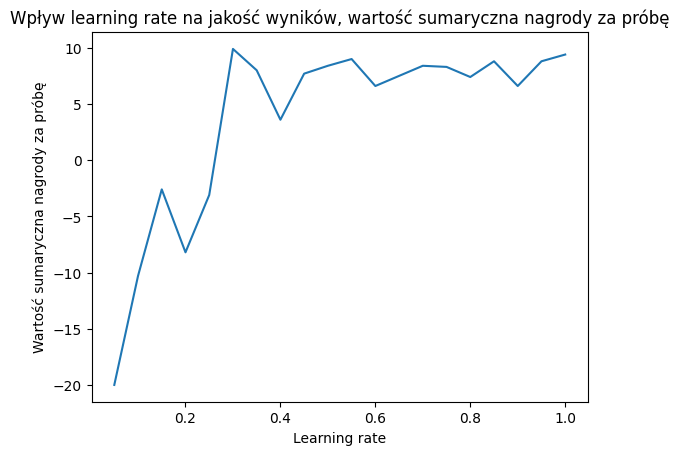

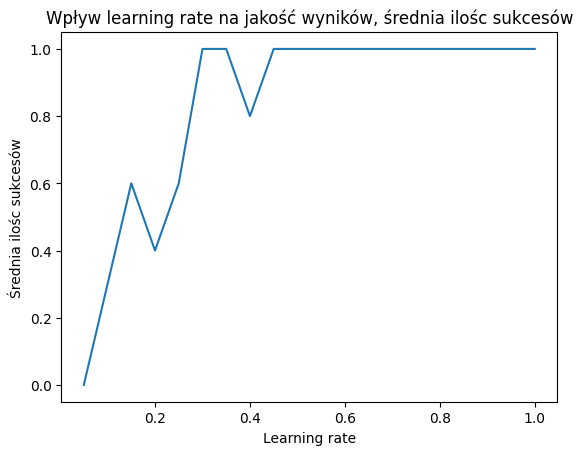

In [ ]:
env = gym.make('Taxi-v3')
results = []

test_runs = 10
ler_rate_increment_per_datapoint = 0.05
max_ler_rate = 1
liczba_epizodów = 1200

reward_results = []
complition_results = []

for i in np.arange(ler_rate_increment_per_datapoint, max_ler_rate+ler_rate_increment_per_datapoint, ler_rate_increment_per_datapoint):
  solver = QLearningSolver(500, 6, epsilon=0.5, learning_rate=i, gamma=0.85)
  q_leraning(env, solver, 80, liczba_epizodów)
  test_result = test_results(env, solver, test_runs, max_steps_per_episode=20)
  reward_results.append(sum(test_result[1])/test_runs)
  complition_results.append(test_result[0]/test_runs)

plot_test_results(reward_results, complition_results, np.arange(ler_rate_increment_per_datapoint, max_ler_rate+ler_rate_increment_per_datapoint, ler_rate_increment_per_datapoint), "Wpływ learning rate na jakość wyników", "Learning rate")

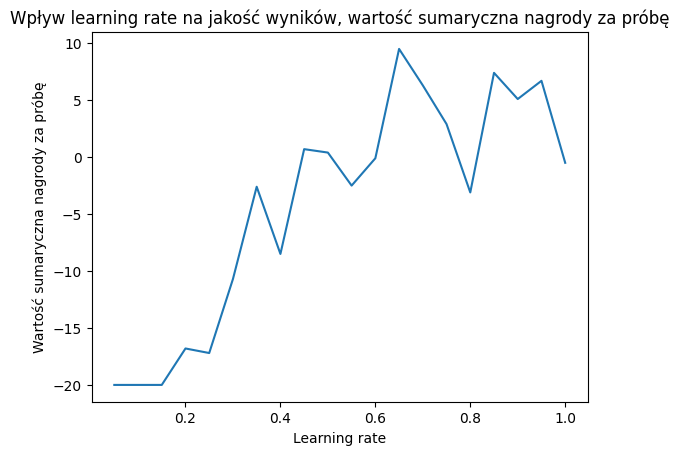

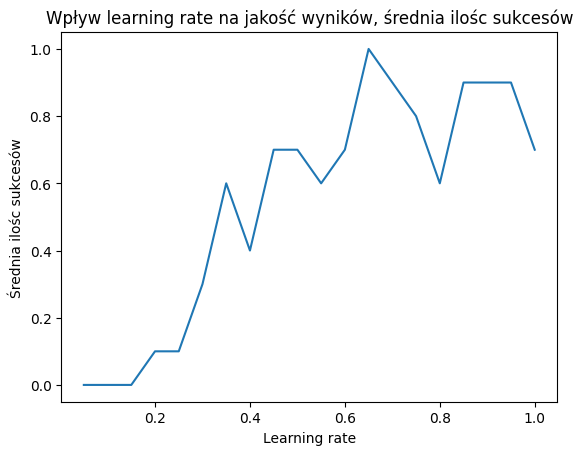

In [ ]:
env = gym.make('Taxi-v3')
results = []

test_runs = 10
ler_rate_increment_per_datapoint = 0.05
max_ler_rate = 1
liczba_epizodów = 600

reward_results = []
complition_results = []

for i in np.arange(ler_rate_increment_per_datapoint, max_ler_rate+ler_rate_increment_per_datapoint, ler_rate_increment_per_datapoint):
  solver = QLearningSolver(500, 6, epsilon=0.5, learning_rate=i, gamma=0.85)
  q_leraning(env, solver, 80, liczba_epizodów)
  test_result = test_results(env, solver, test_runs, max_steps_per_episode=20)
  reward_results.append(sum(test_result[1])/test_runs)
  complition_results.append(test_result[0]/test_runs)

plot_test_results(reward_results, complition_results, np.arange(ler_rate_increment_per_datapoint, max_ler_rate+ler_rate_increment_per_datapoint, ler_rate_increment_per_datapoint), "Wpływ learning rate na jakość wyników", "Learning rate")

Raz ze wzrostem lerning rate wzrasta dokładność algorytmu, ale powyżej 0,4 (dla 1200 epizodów), wzrost ten ustaje i jakość algorytmu się tak naprawdę nie zmienia (przebieg wyznaczników jakości jest w przybliżeniu logarytmiczny). Im mniejsza ilość epizodów tym wzrost jakości jezt dłuższy. Im większy learning rate tym, szybciej algorytm się uczy, ale jeżeli przyjżymy się wzorowi updatowania wartości Q, jeżeli learning rate jest blisko 1 jest duża szanza, że algorytm "zapomni" poprzednią wagę, dlatego osobiści wybrałbym całkiem duże learning rate, ale nie o wartości 1. Dlatego jako learning rate wybrałem 0,9

---



# Wnioski



Najlepsze parametry satysfakcjonujące:
- liczba epizodów testowych 1200
- liczba kroków na epizod 50 (nie widać dużych zmian pomiędzy tymi wartościami)
- epsilon 0.5
- gamma 0.85
- learing rate 0.9

Najlepsze parametry Bezpieczne:
- liczba epizodów testowych 2000
- liczba kroków na epizod 70 (nie widać dużych zmian pomiędzy tymi wartościami)
- epsilon 0.5
- gamma 0.85
- learing rate 0.9


Wiele parametrów ze soba współpracjune np.: zwiększając liczbę epizodów możemy zmniejszyć learning rate i epsilon. Dlatego nie ma jednozncznie najlepszego zestawu parametrów. Warto pamiętać natomiast, że zwiększanie niektórych paramaetrów zwiększa czas obliczeń, natomiast inne na to nie wpływają.

Algorytm ten w tej przestrzeni oferuje cłakiem dobre wyniki szybko (poniżej 5s obliczeń solwera). Minusem jest fakt, że algorytm bardzo przyucza się do środowiska, a co za tym idzie nawet mała zmiana w tym środowisku (np przesunięcie któregoś z pól kolorowych) może spowodować częściowe pogorszenie się jakości wyników (można w kodzie stanów zawierać lokację potrzebnych pól zamiast numeru, ale znacząco zwiększyłoby to przestrzeń obserwacji). Dodatkowo przestrzeń akcji jest dyskretna, a co za tym idzie wykonywanie bardziej złożonych ruchów (np.: zadanie wartości sterowania silników robota) wprowadza ogromną ilość obliczeń. Środowisko te jest stosunkowo małe i pomimo tego długość tabeli q to 3000. Samo boliczenie następnego kroku następuje szybko (tak naprawdę odczytanie najlepszej wartości dla danego stanu). Dlatego uważam,że ten algorytm nie andaje się do użycia w wileu przypadkach rzeczywistych, gdzie przestrzeń oserwacji i akcji jest tak naprawdę nieskończona. Najlepiej nadaje się do użycia jako algorytm w zastosowaniach z ograniczoną ilością stanów i akcji (jak np dla termostatu, stan temperatura którą dzielimy nak kilka przedziałów i na tej podstawie algorytm musi wybrać akcję, czyli jeden z procentów aktywacji elementu grzewczego), dodatkowo takie algorytmy powinny świetnie się spisać jako przeciwnicy w grach (np.: planszowych), bo modyfikując ilość epizodów w trakcie uczenia możan modyfikować poziom przeciwnika.

